**Each presentation will last 30 minutes (20 minutes + 10 minutes for questions).**

During the project we expect you to write a report using a Notebook Python (.ipynb, same format as the practical session).
The articles cover several topics we discussed during the courses (Hamiltonian Monte Carlo, Pseudo-Marginal algorithm, variational inference). Each report is expect to contain (at least):

- A description of the context of the article (model, specific challenge and objective of the algorithm).

- A clear description of the algorithm introduced in the paper with a discussion on its specificities (tuning parameters, etc.) with respect to the algorithm we studied during the courses.

- Numerical illustrations of the algorithm at least on a simulated dataset (with discussion on its performance). 

Note that the papers do not contain the same level of technicalities. To select the project read carefully the abstract and introduction to choose according to your affinities about the algorithms and their objectives. For the most complex papers, we do not expect you to rewrite all the proofs and understand all technical details.

Group 13 - Project 5  
Lotfi Kobrosly, Yuhe Bai, Pierre-André Mikem and Nawel Arab  
**Tuesday 15th December 10h30** -  Project 10 &  Project 5 


# Introduction




# Context

Most of the sampling techniques known so far do not scale to high-dimension and become impractible when the number of data samples is huge.

## log-concave distributions

We first introduce log-concave distributions, a class of probability distributions widely used in modern high dimensional statistics.
>It is the class of all densities $\pi$ on $\mathbb{R}$ or on $\mathbb{R}^n$ that can be written as
$$\pi(x) = \frac{\exp^{g(x)}}{k}$$
Where $g$ is concave, and $k$ is the normalizing constant.

#### Assumptions:
$g: \mathbb{R}^n \to [0, +\infty)$  is a concave, upper semicontinuous function satisfying $\lim\limits_{\Vert x\Vert \rightarrow \infty} q(x) = - \infty$.


## Langevin Markov chain Monte Carlo

Let $\pi$  denote a log-concave probability density function on $\mathbb{R}^n$, one from which it is desired to draw an ensemble of independent and identically distributed samples. To do so, we will first consider Langevin Markov chain Monte Carlo method.

The Metropolis-adjusted Langevin algorithm is a Markov chain Monte Carlo method for obtaining random samples from a probability distribution for which direct sampling is difficult. MALA uses a combination of two mechanisms to generate the states of a random walk that has the target probability distribution as an invariant measure:
+ Candidates are proposed using Langevin dynamics, which use evaluations of the gradient of the target probability density function.
+ The candidates are accepted or rejected using Metropolis–Hastings algorithm.

### Unadjusted Langevin Algorithm
Let $\pi$ be a probability distribution that is everywhere non-zero and differentiable so that $\nabla \mathrm{log} \pi $ is well-defined.

> **Definition** 
Let $\pi$ be a probability distribution on $\mathbb{R}^n$. A process $Y(t)$ is a Langevin diffusion process on $\mathbb{R}^n$ that has $\pi$ as stationary distribution is the solution to the equation$$ dY(t) = \frac{1}{2} \mathrm{log}\pi(Y(t))dt + dW(t), \space Y(0) = y_0 $$where $W$ is the $n$-dimensional Brownian motion (see appendix for definition).

In general, the above stochastic differential equation cannot be solved exactly and the below first-order Euler discretisation is used instead:

>**Definition (Discrete-time approximation of the Langevin diffusion process)**
The discrete-time approximation of the Langevin diffusion process with step size $\delta$ with a forward Euler approximation is the following process, also called ULA$$ L^{(m+1)} = L^{(m)} + \frac{\delta}{2} \nabla \mathrm{log} \pi (L^{(m)}) + \sqrt{\delta} Z^{(m)}$$where$$ Z^{(m)} \sim \mathcal{N} (0, \mathbb{I}_n) $$The parameter $\delta$ controls the incrementation and the variance of the Gaussian pertutbation.

These approaches are interseting typically because of their convergence under certain stability conditions. ULA also presents a good approximation of $Y(t)$ and converges to en ergodic measure that is close to $\pi$.



### Metropolis Adjusted Langevin Algorithme
While ULA approximates $\pi$, the Metropolis Adjusted Langevin corrects this approximation error by introducing a rejection step that guarantees convergence to the correct target density $\pi$. To correct the first-order integration error that is introduced from discretisation, we first consider the above update rule as defining a proposal candidate :
 $$ \tilde{L}^{(m+1)} = L^{(m)} + \frac{\delta}{2} \nabla \mathrm{log} \pi (L^{(m)}) + \sqrt{\delta} Z^{(m)}$$
 

A Metropolis-Hastings acceptance probability is then calculated after a step.
$$ \alpha(L^m, \tilde{L}^{m+1} )= min(1, \frac{\pi(\tilde{L}^{(m+1)}) q(L^m| \tilde{L}^{(m+1)})}{  \pi(L^{m} )q(\tilde{L}^{(m+1)}|L^m)})$$
where
$q(x) \sim \mathcal{N}(  x - \frac{\delta}{2} \nabla \mathrm{log} \pi (x), c)$ is the proposal distribution.


>#### Algorithm 1: Metropolis adjusted Langevin algorithm (MALA)
>**Inuput:** n, step size
>
>**Output:** $L^1,..., L^n$
>
>**for** $m=1,...,n$  **do**
>
>  >Draw independently  $\tilde{L}^{(m+1)} \sim \mathcal{N}(  L^m - \frac{\delta}{2} \nabla \mathrm{log} \pi (L^m),  \frac{\delta}{2} )$ and $U^{m+1} \sim Unif(0,1)$
> set $$
L^{m+1} = \left\{
    \begin{array}{ll}
        \tilde{L}^{m+1} & \mbox{if } U^{m+1} \leq \alpha(L^m, \tilde{L}^{m+1} )  \\
        L^m & \mbox{otherwise}
    \end{array}
\right.
$$
**end**

### Limitations of ULA and the Langevin MCMC
These approaches are unfortunately not very useful:

* The Langevin diffusion process $Y(t)$ is not easy to sample from in general, which makes it not very versatile.
- ULA can get transient in certain cases (especially when $\pi$ belongs to a certain class). Even with the addition of a Metropolis-Hastings rejection step to ensure convergence with MALA, geometric ergodicity is not always guarenteed (see Appendix for geometric ergodicity definition).
+ $\pi$ is required to be $\mathcal{C}^1$ for MALA to work, which limits the scope of the distributions we can approach.

is the transition probability density from  such that $$q() \propto \exp() $$ 


### Limitations of MALA




### plot graphs .....


## A proximal point of view 

# Implementation of matlab codes to python codes 
**src**  
- pmala.m
- pula.m  

**demos**
- demo_pmala_audioCS.m
- demo_pmala_diabetes.m
- demo_pmala_illustrativeExample.m
- demo_pula_illustrativeExample.m  

**utils**  
- createDictionary.m
- proxQuartic.m



In [1]:
import scipy.io as sio
import random
from scipy.sparse import coo_matrix
import numpy as np
import time
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

## pmala

**This python function implements the proximal unadjusted Langevin algorithm described in**  
[1] M. Pereyra, "Proximal Markov chain Monte Carlo algorithms," submitted to Journal Royal Statistics Society: Series B.  
E-print available on Arxiv: http://arxiv.org/abs/1306.0187  
**Inputs**  
- X0 : initial state of the Markov chain
- proxg : function handler of type @(X,lambda) for the lambda-proximity mapping of g(x) = \log\pi(x)
- options (stucture) 

  **Required**:    
  - options.samples : number of output samples
  - options.delta : initial value of the time-discretisation step(this value may be adapted during the burn-in period to improve the acceptance rate)

  **Optional**:  
  - options.thinning : thinning factor (i.e., number of MCMC iterations per output sample)  
  - options.display    : display progressbar (1) do not display (0)
  - options.burnIn     : number of burn-in iterations
  - options.targetRate : desired acceptance rate
  - options.updateDelta: the value of delta is adjuted every 'options.updateDelta' iterations (during the burn-in period). Adaptation is disabled by setting options.updateDelta = 0

**Outputs**
- Xchain : Makov chain generated by P-ULA 
- gTrace : trace of g(X)
- acceptTrace : trace of accepted moves
- time : cpu time
- delta : final value of delta after the burn-in adaptation

In [2]:
def pmala(X0=None,g=None,proxg=None,options=None):
# Check for required inputs
# Check for optional inputs
# ----------------------------------------------------------- Simulation setup -----------------------------------------------
  # Allocate chains
  n = X0.shape # gives num of rows and cols of X0
  Xchain = np.zeros((int(options['samples']),)+n) # dimension 3 
  #print(Xchain.shape)
  gTrace = np.zeros(int(options['samples'] * options['thinning']))  
  acceptTrace = np.zeros(int(options['samples'] * options['thinning'])) 

  # Initialize variables
  delta = options['delta']       # delta controls the proposal variance, the discrete-time step length and the Moreau approximation
  Xcur = X0               # set initial state as current state
  proxgXcur = proxg(Xcur,delta/2)    # pre-compute proxg(Xcur)
  gXcur=g(Xcur)              # pre-compute g(Xcur)
  gTrace[0]=gXcur             # record value g(Xcur) as a scalar summary
  if n[1]==1:
    Xchain[0,:] = Xcur;             # record initial sample (X is in vector form)
  else:
    Xchain[0,:,:] = Xcur;           # record initial sample (X is in matrix form)
    
  # Set the appropriate norm for 'X'
  if n[1]==1:
    p = 2      # L2 norm (X is in vector form)
  else:
    p = 'fro'  # Frobenius (X is in matrix form)
  # --------------------------------------------------------- Run simulation -----------------------------------------------
  # activate "progress bar" if options['display'] = 1
  # if options['display']:
  #   progressbar

  time_start=time.time()
  #for ii in tqdm(range(1, int(options['samples'] * options['thinning']))): # with progress bar
  for ii in range(1, int(options['samples'] * options['thinning'])):
    # Generate candidate using P-ULA proposal
    Xnew = proxgXcur + np.sqrt(delta)*np.random.randn(n[0],n[1]) # may be changed
    
    # Compute Metropolis-Hastings ratio: target ratio
    gXnew = g(Xnew)
    logPiRatio = gXnew - gXcur
    # Compute Metropolis-Hastings ratio: proposal ratio
    proxgXnex = proxg(Xnew,delta/2)
    logPropRatio = (np.linalg.norm(Xnew - proxgXcur,p)**2 - np.linalg.norm(Xcur - proxgXnex,p)**2)/(2*delta);
    
    # Accept-Reject candidate
    if np.log(np.random.rand(1)) < (logPiRatio + logPropRatio):
      Xcur = Xnew;                # set candidate as new current
      acceptTrace[ii]=1               # record that the candidate was accepted
      proxgXcur = proxgXnex           # record proxg(Xnew) for next iteration
      gXcur = gXnew              # record g(Xnew) for next iteration
    # Record value g(Xcur) as a scalar summary
    gTrace[ii] = gXcur
    
    # Record sample (with thinning)
    if not np.mod(ii,options['thinning']):
      if n[1]==1:
        Xchain[round(ii/options['thinning']) ,:] = Xcur;    # X is vector
      else:
        Xchain[round(ii/options['thinning']),:,:] = Xcur;  # X is matrix

    # Adapt the value of delta to achieve an appropriate acceptance rate (only during burn-in period)
    if options['updateDelta']:
      if ii < options['burnIn']*options['thinning']:
        if not np.mod(ii,options['updateDelta']):
                
          # Estimate acceptance probability over the last
          # 'options.updateDelta' iterations
          accRate = np.mean(acceptTrace[int(ii-options['updateDelta']): int(ii)])
                
          # If accRate is 1% higher than targetRate increase delta
          # by 25%, otherwise if 1% lower decrease by 20%.
          if accRate>options['targetRate']*1.01:
            delta = delta*1.25
          elif accRate<options['targetRate']/1.01:
            delta = delta*0.8


    
  time_s = time.time()-time_start
  return Xchain,gTrace,acceptTrace,time_s,delta




In [3]:
# test
# pmala(X0,g1,proxg1,options)

## createDictionary

## demo_pmala_audioCS.m

In [7]:
# Load data
# z - MIDI interpretation of the 'Mary had a little lamb' medoly 
# containing 319725 samples
# sig2 - value of sigma^2 (2.2500e-04)
import scipy.io as sio
audio_data = sio.loadmat('data/audioCSdata.mat')
z = audio_data['z']
sig2 = audio_data['sig2']
n = z.size
print(n)
print(sig2)

319725
[[0.000225]]


In [8]:
# Experiment setup
# Create matrix Psi: subsampling operator that collects k random entries of z
import random
from scipy.sparse import coo_matrix
import numpy as np
k = 456 # number of samples
ii = sorted(random.sample(range(n),k)) # divide randomly into 456 samples, different length，ii is their index
# the kth ii of the kth line is 1, 456 1s in total
Psi = coo_matrix((np.ones(k), (range(k), ii)), shape=(k,n)) # toarray()
print(ii)
print(Psi)
# Create matrix Phi: dictionary with piano notes providing a sparse representation for MIDI signals


[178, 642, 1413, 1948, 2588, 3244, 5191, 5505, 5826, 6319, 7419, 7775, 7932, 8029, 8155, 8413, 8664, 9978, 10156, 10259, 10721, 11126, 11262, 11467, 12077, 13585, 14657, 14742, 14909, 15250, 15916, 18236, 19516, 20342, 20857, 22084, 23351, 24974, 25525, 26279, 27413, 27698, 29472, 31564, 32189, 32454, 33072, 33776, 35708, 36271, 37705, 38559, 38573, 38697, 39269, 39945, 40434, 42103, 44923, 45267, 45528, 45755, 45855, 50473, 50992, 51308, 51784, 52511, 53379, 53391, 54140, 55830, 56729, 56765, 56935, 57195, 57935, 58236, 60399, 61220, 62211, 62525, 63611, 63835, 66139, 66410, 68164, 69311, 69336, 71104, 71583, 72304, 72990, 73109, 74548, 74580, 75016, 75661, 76588, 77367, 77546, 77921, 78116, 79287, 79780, 79794, 81088, 82017, 82239, 82253, 82359, 83056, 84106, 84730, 85194, 85225, 87132, 87775, 88254, 89138, 89265, 89266, 90070, 90400, 91019, 91160, 91271, 91981, 92788, 93084, 93381, 94007, 94382, 94512, 97087, 97857, 98983, 99074, 100447, 102436, 102869, 103086, 103621, 104065, 10534

## Display results

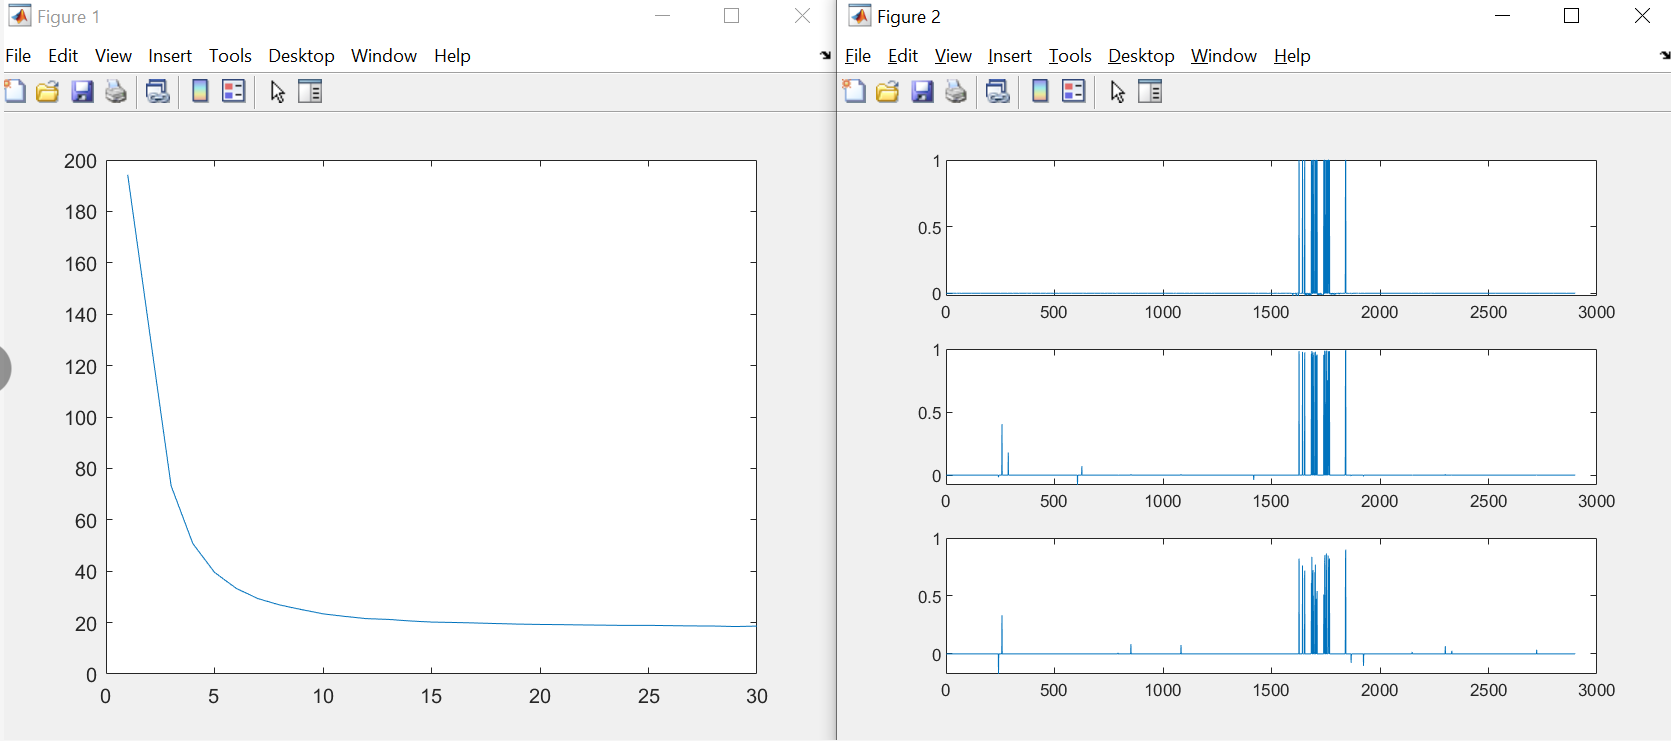

## demo_pmala_diabets

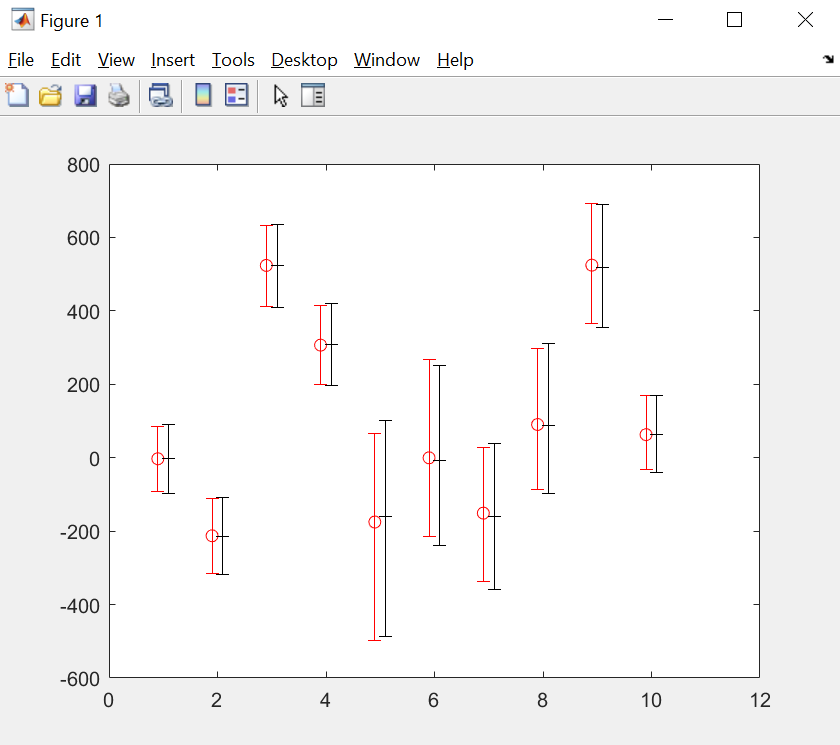

# demo_pmala_illustrativeExample

## 1 - Simulate from univariate Laplace distribution

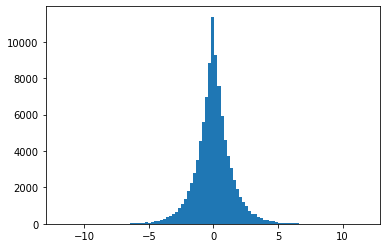

In [9]:
# Define g = \log\pi(x)
def g1(X):
  return -np.abs(X)
# Define proximity mapping of g(x) = log\pi(x)
def proxg1(X, lamda):
  #print(np.sign(X),np.abs(X),lamda)
  return np.dot(np.sign(X),(np.max((np.abs(X),lamda))-lamda))
# Sampler setup
options = {}
options['samples'] = 1.1e5 # total number of samples
options['thinning'] = 1. # thinning factor (i.e., iterations per sample)
options['delta'] = 0.02 # value of time-discretisation step "delta"
options['display'] = 0. # do not display progressbar
options['targetRate'] = 0.6 # target an acceptance probability of around 60%
options['updateDelta'] = 200. # adjust the value of delta every 200 iterations
options['burnIn'] = 1e4 # adjust the value of delta only during the first 1e4 iterations
X0 = np.matrix(np.random.rand(1, 1)) # set initial state
# Run P-MALA
Xchain,gTrace,acceptTrace,time_s,delta = pmala(X0,g1,proxg1,options)
Xchain = Xchain.reshape(Xchain.shape[0],Xchain.shape[1])
plt.hist(Xchain[10000:],101)
plt.show()


## 2 - Simulate from univariate Gaussian distribution


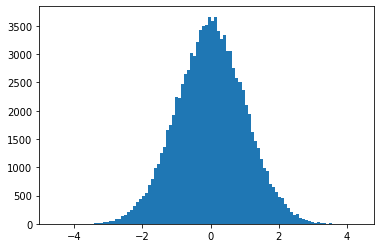

In [10]:
# Define g = \log\pi(x)
def g2(X):
  return -0.5 * pow(X,2)
# Define proximity mapping of g(x) = log\pi(x)
def proxg2(X, lamda):
  return X/(1+lamda)
# Sampler setup
options = {}
options['samples'] = 1.1e5 # total number of samples
options['thinning'] = 1. # thinning factor (i.e., iterations per sample)
options['delta'] = 0.02 # value of time-discretisation step "delta"
options['display'] = 0. # do not display progressbar
options['targetRate'] = 0.6 # target an acceptance probability of around 60%
options['updateDelta'] = 200. # adjust the value of delta every 200 iterations
options['burnIn'] = 1e4 # adjust the value of delta only during the first 1e4 iterations
X0 = np.random.rand(1, 1) # set initial state
# Run P-MALA
Xchain,gTrace,acceptTrace,time_s,delta = pmala(X0,g2,proxg2,options)
Xchain = Xchain.reshape(Xchain.shape[0],Xchain.shape[1])
plt.hist(Xchain[10000:],101)
plt.show()

## 3 - Simulate from univariate quartic (4th order polynomial) distribution


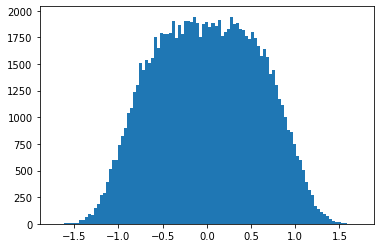

In [11]:
# Define g = \log\pi(x)
def g3(X):
  return -pow(X,4)
# Define proximity mapping of g(x) = log\pi(x)
# Compute prox of pi(x) \ propto exp(-gamma*x^4)
def proxg3(X, lamda):
  p = 1.0/(4.*lamda)
  q = 1.0*X/(4.*lamda)
  w3 = (np.sqrt(q**2+(4./27)*p**3)-q)/2.
  w = pow(w3, (1./3))
  u = p/(3.*w) - w
  return u

# Sampler setup
options = {}
options['samples'] = 1.1e5 # total number of samples
options['thinning'] = 1. # thinning factor (i.e., iterations per sample)
options['delta'] = 0.02 # value of time-discretisation step "delta"
options['display'] = 0. # do not display progressbar
options['targetRate'] = 0.6 # target an acceptance probability of around 60%
options['updateDelta'] = 200. # adjust the value of delta every 200 iterations
options['burnIn'] = 1e4 # adjust the value of delta only during the first 1e4 iterations
X0 = np.random.rand(1, 1) # set initial state
# Run P-MALA
Xchain,gTrace,acceptTrace,time_s,delta = pmala(X0,g3,proxg3,options)
Xchain = Xchain.reshape(Xchain.shape[0],Xchain.shape[1])
plt.hist(Xchain[10000:],101)
plt.show()

## 4 - Simulate from univariate uniform  distribution


C:\Users\Cecile\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


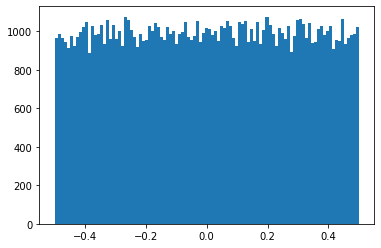

In [12]:
# Define g = \log\pi(x)
def g4(X):
  return np.log(np.double(abs(X)<0.5))
# Define proximity mapping of g(x) = log\pi(x)
def proxg4(X, lamda):
  return min(max(-1/2,X),1/2)
# Sampler setup
options = {}
options['samples'] = 1.1e5 # total number of samples
options['thinning'] = 1. # thinning factor (i.e., iterations per sample)
options['delta'] = 0.02 # value of time-discretisation step "delta"
options['display'] = 0. # do not display progressbar
options['targetRate'] = 0.6 # target an acceptance probability of around 60%
options['updateDelta'] = 200. # adjust the value of delta every 200 iterations
options['burnIn'] = 1e4 # adjust the value of delta only during the first 1e4 iterations
X0 = np.random.rand(1, 1)/2 -1/2 # set initial state
# Run P-MALA
Xchain,gTrace,acceptTrace,time_s,delta = pmala(X0,g4,proxg4,options)
Xchain = Xchain.reshape(Xchain.shape[0],Xchain.shape[1])
plt.hist(Xchain[10000:],101)
plt.show()

## Display results


C:\Users\Cecile\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


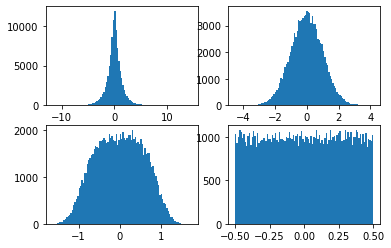

In [13]:
# Run P-MALA
Xchain,gTrace,acceptTrace,time_s,delta = pmala(X0,g1,proxg1,options)
Xchain = Xchain.reshape(Xchain.shape[0],Xchain.shape[1])
plt.subplot(2,2,1)
plt.hist(Xchain[10000:],101)

Xchain,gTrace,acceptTrace,time_s,delta = pmala(X0,g2,proxg2,options)
Xchain = Xchain.reshape(Xchain.shape[0],Xchain.shape[1])
plt.subplot(2,2,2)
plt.hist(Xchain[10000:],101)

Xchain,gTrace,acceptTrace,time_s,delta = pmala(X0,g3,proxg3,options)
Xchain = Xchain.reshape(Xchain.shape[0],Xchain.shape[1])
plt.subplot(2,2,3)
plt.hist(Xchain[10000:],101)

Xchain,gTrace,acceptTrace,time_s,delta = pmala(X0,g4,proxg4,options)
Xchain = Xchain.reshape(Xchain.shape[0],Xchain.shape[1])
plt.subplot(2,2,4)
plt.hist(Xchain[10000:],101)
plt.show()


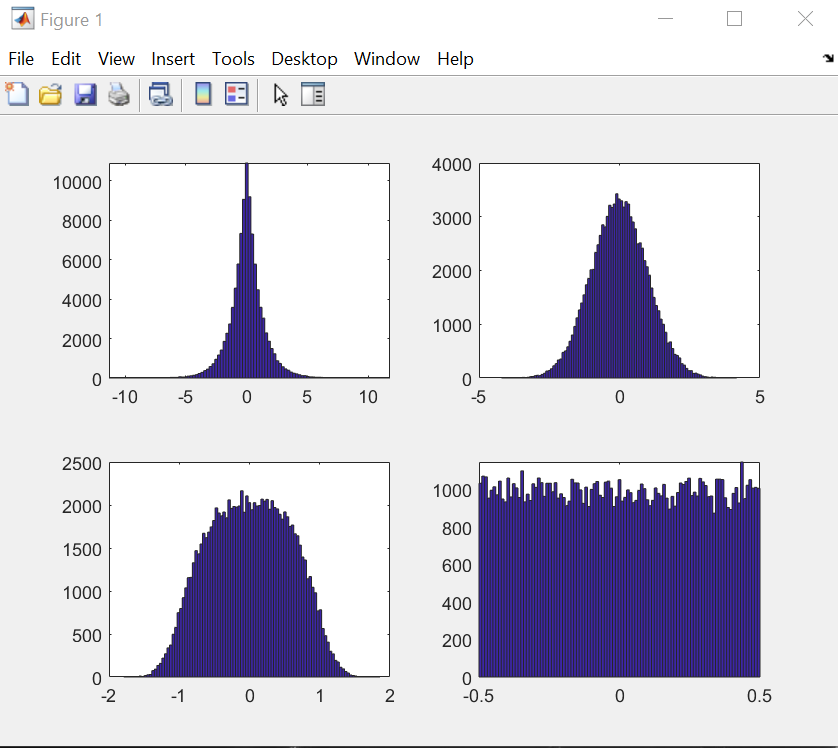